# Semantic Segmentation Introduction

![](https://cdn-images-1.medium.com/max/2600/1*rZ1vDrOBWqISFiNL5OMEbg.jpeg)

<b>Semantic segmentation</b> partitions an image into regions which hold semantic meaning. This is very common in satellite imagery analysis where a common use is <b>Land Use Classification</b>.  The Land Use Classification can then be used to perform <b>Change Detection</b>.

![](https://sites.temple.edu/psmgis/files/2018/07/11111Capture-1024x428.jpg)

In this seminar, we will use a deep learning based semantic segmentation model to classify buildings. We will use the Massachusetts Road and Building Detection Datasets for this task.

# Massachusetts Road and Building Detection Datasets

The Massachusetts Road and Building Detection Datasets can be found at the following link:

https://www.cs.toronto.edu/~vmnih/data/

These datasets were put together as part of Volodymyr Mnih's PhD Thesis in 2013. From the thesis:

<i>"The Massachusetts Buildings Dataset consists of 151 aerial images of the Boston
area, with each of the images being 1500 × 1500 pixels for an area of 2.25 square
kilometers. Hence, the entire dataset covers roughly roughly 340 square kilometers"</i>

The images are resampled to 1m GSD from their original resolutions. More information about the images can be found in Mnih's thesis: <i>Machine Learning for Aerial Image Labeling</i>

## Obtaining the Data

The following shell script will download all the data.

In the remainder of this notebook, we are assuming the data is stored in the following format:

## Loading and Visualizing the Data

In [1]:
import os

data_dir = "/Users/ponl/Projects/GMUSeminar/data/"

bldg_dir = os.path.join(data_dir, "mass_buildings")
road_dir = os.path.join(data_dir, "mass_roads")

In [2]:
os.listdir(bldg_dir)

['valid', 'test', 'train']

In [3]:
def load_image_paths(path, name):
    # test, train, valid
    ttv = os.listdir(path)
    
    for ttv_typ in ttv:
        # <path>/<test-train-valid>
        typ_path = os.path.join(path, ttv_typ)
        
        # map, sat
        ms = os.listdir(typ_path)
        
        for ms_typ in ms:
            # <path>/<test-train-valid>/<map-sat>
            ms_path = os.path.join(typ_path, ms_typ)
            ms_img_fls = os.listdir(ms_path)
            
            # Only maintain tif/tiff files
            ms_img_fls = [fl for fl in ms_img_fls if fl.endswith(".tiff") or fl.endswith(".tif")]
            
            # Get the scene id
            # 23428915_15.tiff -> 23428915_15
            scene_ids = [fl.replace(".tiff", "").replace(".tif", "") for fl in ms_img_fls]
            
            # Expand to full path
            ms_img_fls = [os.path.join(ms_path, fl) for fl in ms_img_fls]
            
            # Record the map and sat files for each scene
            for fl, scene_id in zip(ms_img_fls, scene_ids):
                images[name][ttv_typ][scene_id][ms_typ] = fl

In [4]:
from collections import defaultdict

images = {}
images["buildings"] = {"train": defaultdict(dict), "test": defaultdict(dict), "valid": defaultdict(dict)}
images["roads"] = {"train": defaultdict(dict), "test": defaultdict(dict), "valid": defaultdict(dict)}

load_image_paths(bldg_dir, "buildings")
load_image_paths(road_dir, "roads")

In [5]:
images["buildings"]["train"]["23428915_15"]

{'map': '/Users/ponl/Projects/GMUSeminar/data/mass_buildings/train/map/23428915_15.tif',
 'sat': '/Users/ponl/Projects/GMUSeminar/data/mass_buildings/train/sat/23428915_15.tiff'}

In [6]:
import numpy as np
from PIL import Image

def data_generator(files, mode="train", batch_size=32):
    while True:
        all_scenes = list(files[mode].keys())
        
        # Randomly choose scenes to use for data
        scene_ids = np.random.choice(all_scenes, size=batch_size, replace=True)
        
        X_fls = [files[mode][scene_id]["sat"] for scene_id in scene_ids]
        Y_fls = [files[mode][scene_id]["map"] for scene_id in scene_ids]
        
        X = np.array([np.asarray(Image.open(fl), dtype=np.float) / 255 for fl in X_fls])
        Y = np.array([np.asarray(Image.open(fl), dtype=np.float)[:,:,:1] / 255 for fl in Y_fls])
        
        yield X, Y

In [7]:
train_building_gen = data_generator(images["buildings"])

In [8]:
X, Y = next(train_building_gen)

In [9]:
from matplotlib import pyplot

def show_images(x, y):
    pyplot.figure(figsize=(20,20))
    pyplot.subplot(1,2,1)
    pyplot.imshow(x)
    pyplot.subplot(1,2,2)
    pyplot.imshow(y[:,:,0])

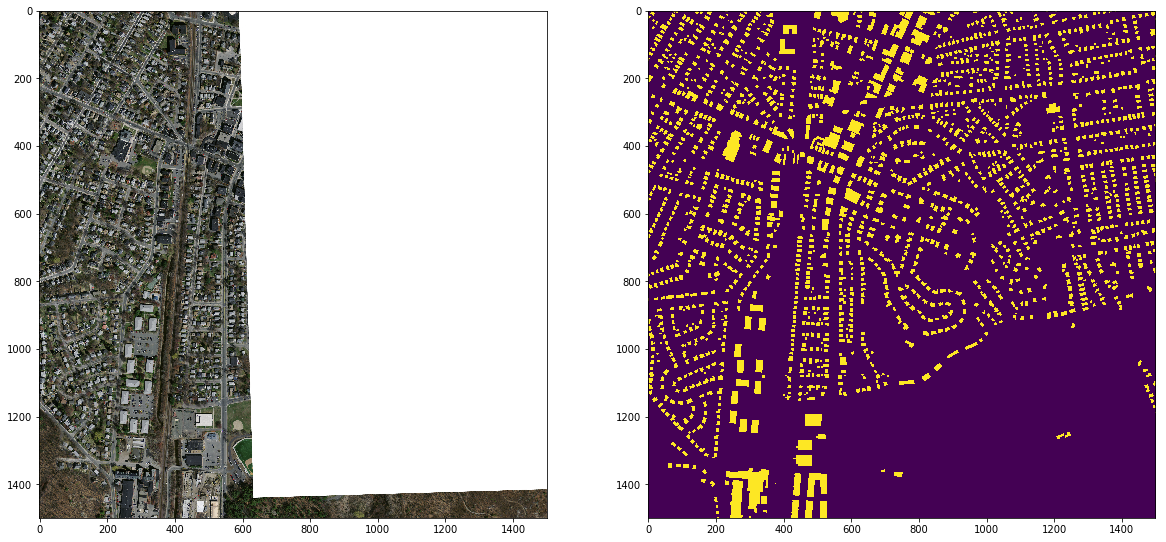

In [10]:
show_images(X[0], Y[0])

In [11]:
X[0].shape

(1500, 1500, 3)

In [12]:
Y[0].shape

(1500, 1500, 1)

These images will be too large to train with since dense tensors take up a lot of memory. Instead, we will pull random chips of a given size from the images.

Let's rework the data generator:

In [13]:
import numpy as np
from PIL import Image

def data_generator(files, size=256, mode="train", batch_size=32):
    while True:
        all_scenes = list(files[mode].keys())
        
        # Randomly choose scenes to use for data
        scene_ids = np.random.choice(all_scenes, size=batch_size, replace=True)
        
        X_fls = [files[mode][scene_id]["sat"] for scene_id in scene_ids]
        Y_fls = [files[mode][scene_id]["map"] for scene_id in scene_ids]
        
        X = np.array([np.asarray(Image.open(fl), dtype=np.float) / 255 for fl in X_fls])
        Y = np.array([np.asarray(Image.open(fl), dtype=np.float)[:,:,:1] / 255 for fl in Y_fls])
        
        n, h, w, c = X.shape
        
        I = np.random.randint(0, h-size, size=batch_size)
        J = np.random.randint(0, w-size, size=batch_size)
        
        X = np.array([x[i:(i+size), j:(j+size)] for x, i, j in zip(X, I, J)])
        Y = np.array([y[i:(i+size), j:(j+size)] for y, i, j in zip(Y, I, J)])
        
        yield X, Y

In [14]:
train_building_gen = data_generator(images["buildings"])

In [15]:
X, Y = next(train_building_gen)

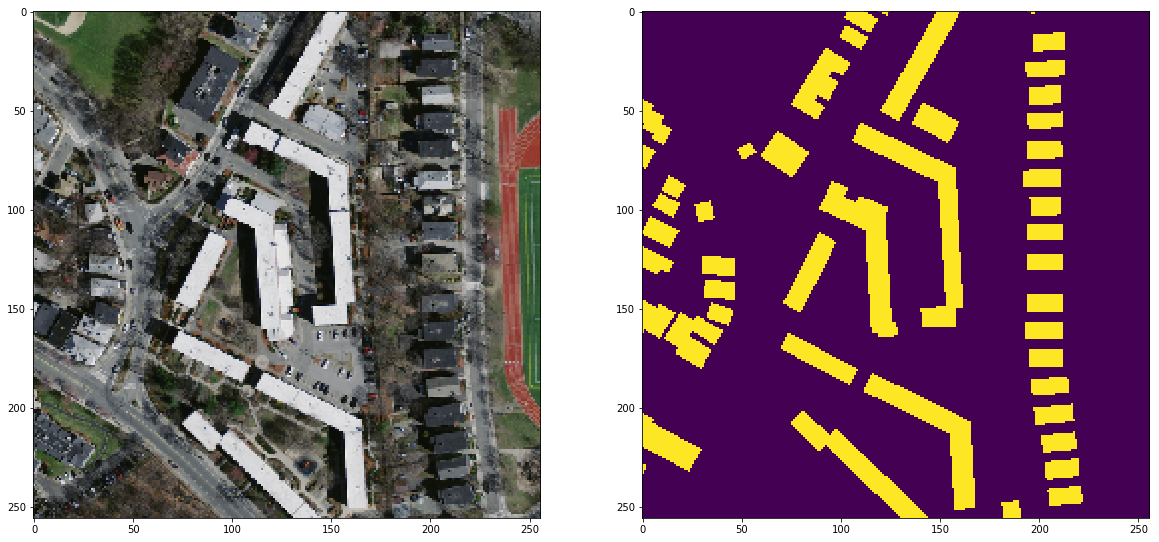

In [16]:
show_images(X[0], Y[0])

# U-Net Architecture

![](https://www.depends-on-the-definition.com/wp-content/uploads/2018/07/unet.png)

<b>Binary Cross Entropy</b> is given by:
$$−(y\log(p)+(1−y)\log(1−p))$$

In [65]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose

In [227]:
class UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=32):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = UNet.build_block(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = UNet.build_block(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = UNet.build_block(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = UNet.build_block(x, nfilters=ifilters * 8)
        
        # Bottom block
        x, _ = UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        
        # In: 16x16, Out: 32x32
        x, _ = UNet.build_block(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = UNet.build_block(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = UNet.build_block(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = UNet.build_block(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="binary_crossentropy", optimizer=Adam())
        
    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s

In [228]:
unet = UNet(X[0].shape)

In [229]:
unet._model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 256, 256, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 256, 256, 32) 0           conv2d_144[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 256, 256, 32) 9248        activation_144[0][0]             
__________________________________________________________________________________________________
activation

In [230]:
loss = unet._model.train_on_batch(X, Y)

In [231]:
print(loss)

0.68294644


In [232]:
unet._model.fit_generator(train_building_gen, steps_per_epoch=20, epochs=20)

Epoch 1/20
20/20 [==============================] - 73s 4s/step - loss: 0.5605
Epoch 2/20
20/20 [==============================] - 72s 4s/step - loss: 0.4019
Epoch 3/20
20/20 [==============================] - 73s 4s/step - loss: 0.3474
Epoch 4/20
20/20 [==============================] - 72s 4s/step - loss: 0.3181
Epoch 5/20
20/20 [==============================] - 73s 4s/step - loss: 0.2999
Epoch 6/20
20/20 [==============================] - 73s 4s/step - loss: 0.2725
Epoch 7/20
20/20 [==============================] - 73s 4s/step - loss: 0.2716
Epoch 8/20
20/20 [==============================] - 73s 4s/step - loss: 0.2508
Epoch 9/20
20/20 [==============================] - 73s 4s/step - loss: 0.2518
Epoch 10/20
20/20 [==============================] - 73s 4s/step - loss: 0.2278
Epoch 11/20
20/20 [==============================] - 73s 4s/step - loss: 0.2262
Epoch 12/20
20/20 [==============================] - 73s 4s/step - loss: 0.2299
Epoch 13/20
20/20 [==============================

KeyboardInterrupt: 

In [233]:
Z = unet._model.predict(X)

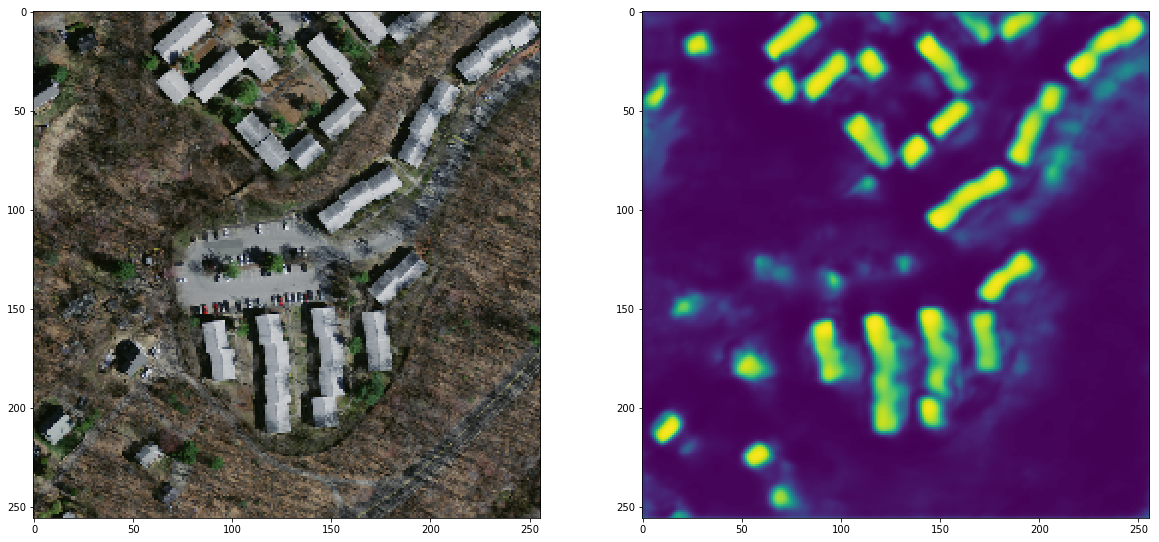

In [236]:
i = 2
show_images(X[i], Z[i])

In [250]:
unet._model.fit_generator(train_building_gen, steps_per_epoch=20, epochs=5)

Epoch 1/5
20/20 [==============================] - 73s 4s/step - loss: 0.2074
Epoch 2/5
20/20 [==============================] - 73s 4s/step - loss: 0.2233
Epoch 3/5
20/20 [==============================] - 73s 4s/step - loss: 0.2055
Epoch 4/5
20/20 [==============================] - 73s 4s/step - loss: 0.2267
Epoch 5/5
20/20 [==============================] - 73s 4s/step - loss: 0.1986


In [253]:
Z = unet._model.predict(X)

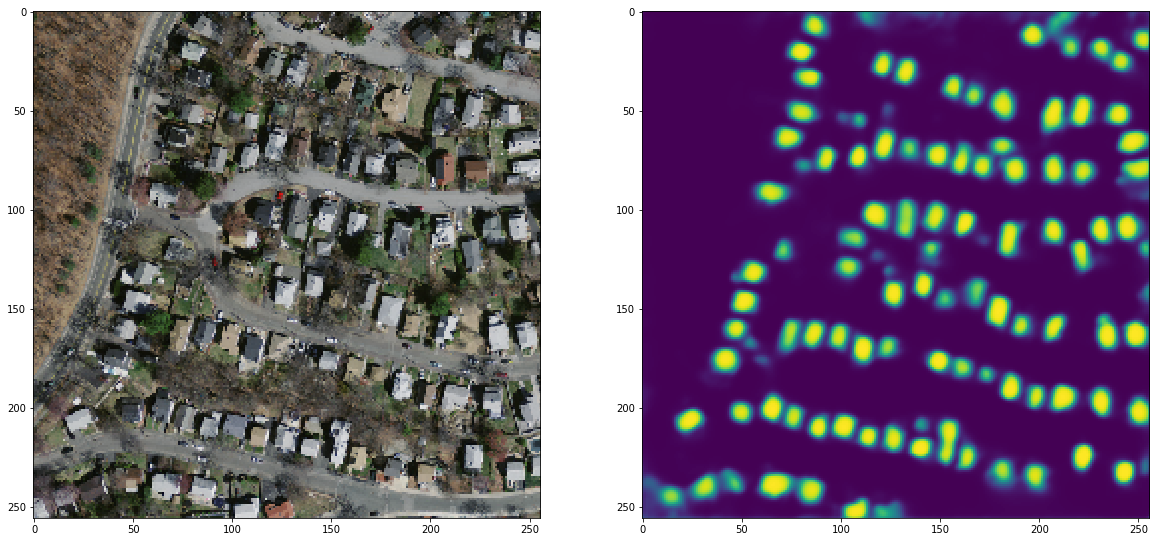

In [256]:
i = 10
show_images(X[i], Z[i])

In [257]:
unet._model.fit_generator(train_building_gen, steps_per_epoch=20, epochs=5)

Epoch 1/5
20/20 [==============================] - 71s 4s/step - loss: 0.1920
Epoch 2/5
20/20 [==============================] - 71s 4s/step - loss: 0.1994
Epoch 3/5
20/20 [==============================] - 71s 4s/step - loss: 0.1922
Epoch 4/5
20/20 [==============================] - 73s 4s/step - loss: 0.1955
Epoch 5/5
20/20 [==============================] - 72s 4s/step - loss: 0.1914


In [258]:
Z = unet._model.predict(X)

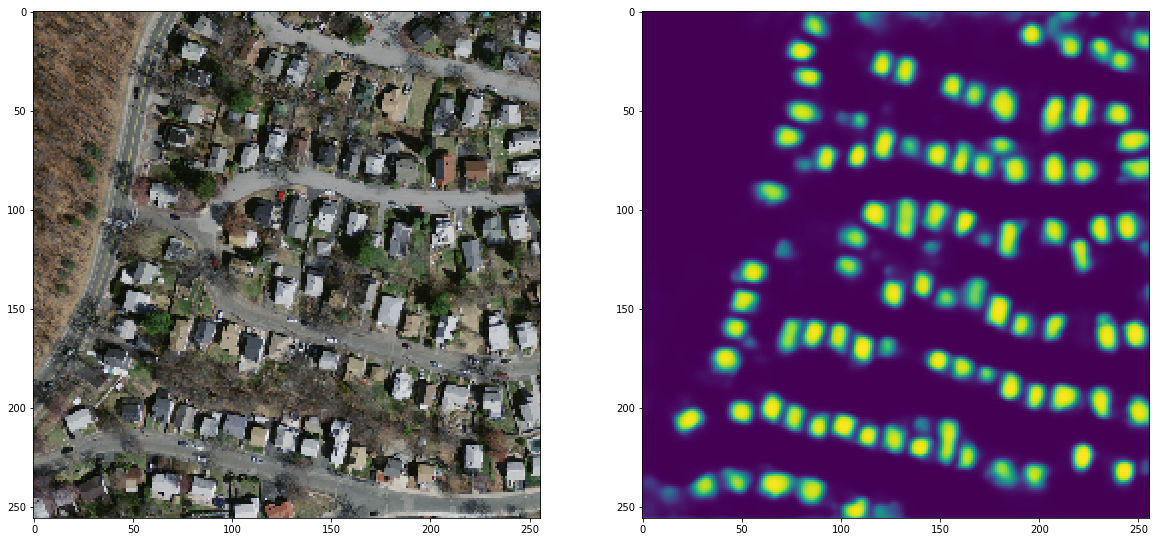

In [259]:
i = 10
show_images(X[i], Z[i])